# EDA🔎 and segmentation baseline with Lightning⚡Flash

see: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html

In [1]:
!pip uninstall -y torchtext
# !pip install -q --upgrade torch torchvision
!pip install -q "lightning-flash[image]" "torchmetrics<0.8" albumentations
!pip install -q -U timm segmentation-models-pytorch
!pip install -q -U "kaggle-imsegm @ https://github.com/Borda/kaggle_image-segm/archive/refs/heads/main.zip" --no-cache

! pip list | grep -e torch -e lightning -e kaggle
! nvidia-smi -L

efficientnet-pytorch          0.6.3
kaggle                        1.5.12
kaggle-imsegm                 0.1.0.dev0
kaggle-instsegm               0.1.0.dev0
lightning-bolts               0.5.0
lightning-flash               0.7.3
pytorch-lightning             1.6.0                /home/jirka/.local/lib/python3.8/site-packages
segmentation-models-pytorch   0.2.1
torch                         1.11.0+cu113
torchaudio                    0.11.0+cu113
torchmetrics                  0.7.3
torchvision                   0.12.0+cu113
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-7b693b1c-bfe4-4e91-b886-7b980b9bc60d)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-efc5218d-a533-651a-08bf-97916434d595)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-f0687420-e4a4-c246-3044-e5224f456289)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-bc52cd8b-d3d2-6173-ed00-67af6a2c994c)
GPU 4: NVIDIA A100-SXM4-40GB (UUID: GPU-f6ceefea-f265-f7ce-ace4-2b354f844889)
GPU 5: NVIDIA A100-SXM4-40GB (UUID: GPU-a5b5571a-b037-3000-0735-a899935eaff7)
GPU 6:

In [2]:
%matplotlib inline

import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "/home/jirka/Datasets/uw-madison-gi-tract-image-segmentation"
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
display(df_train.head())

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
all_imgs = glob.glob(os.path.join(DATASET_FOLDER, "train", "case*", "case*_day*", "scans", "*.png"))
all_imgs = [p.replace(DATASET_FOLDER, "") for p in all_imgs]

print(f"images: {len(all_imgs)}")
print(f"annotated: {len(df_train['id'].unique())}")

images: 38496
annotated: 38496


## 🔎 Explore and enrich dataset

Take the input train table and parse some additiona informations

In [4]:
from pprint import pprint
from kaggle_imsegm.data import extract_tract_details

pprint(extract_tract_details(df_train['id'].iloc[0], DATASET_FOLDER))

df_train[['Case','Day','Slice', 'image', 'image_path', 'height', 'width']] = df_train['id'].apply(
    lambda x: pd.Series(extract_tract_details(x, DATASET_FOLDER))
)
display(df_train.head())

{'Case': 123,
 'Day': 20,
 'Slice': '0001',
 'height': 266,
 'image': 'slice_0001_266_266_1.50_1.50.png',
 'image_path': 'train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 'width': 266}


,id,class,segmentation,Case,Day,Slice,image,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266


Compare timeseries and stack sizes

## Browse the 3D image

see the full version (without importing own package) in https://www.kaggle.com/code/jirkaborovec/tract-segm-eda-3d-data-browser

In [5]:
from ipywidgets import interact, IntSlider
from kaggle_imsegm.data import load_volume_from_images, create_tract_segm
from kaggle_imsegm.visual import show_tract_volume

CASE = 108
DAY = 10
IMAGE_FOLDER = os.path.join(DATASET_FOLDER, "train", f"case{CASE}", f"case{CASE}_day{DAY}", "scans")
vol = load_volume_from_images(img_dir=IMAGE_FOLDER)
print(vol.shape)

df_ = df_train[(df_train["Case"] == CASE) & (df_train["Day"] == DAY)]
segm = create_tract_segm(df_vol=df_, vol_shape=vol.shape)

def interactive_show(volume):
    vol_shape = volume.shape
    interact(
        lambda x, y, z: plt.show(show_tract_volume(volume, segm, z, y, x)),
        z=IntSlider(min=0, max=vol_shape[0], step=5, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1], step=5, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2], step=5, value=int(vol_shape[2] / 2)),
    )

(144, 266, 266)


In [6]:
interactive_show(vol)

interactive(children=(IntSlider(value=133, description='x', max=266, step=5), IntSlider(value=133, description…

## Prepare flatten dataset

In [7]:
DATASET_IMAGES = "dataset-flash/images"
DATASET_SEGMS = "dataset-flash/segms"

for rdir in (DATASET_IMAGES, DATASET_SEGMS):
    for sdir in ("train", "val"):
        os.makedirs(os.path.join(rdir, sdir), exist_ok=True)

In [8]:
df_train['Case_Day'] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_train.iterrows()]

CASES_DAYS = list(df_train['Case_Day'].unique())
VAL_SPLIT = 0.1
VAL_CASES_DAYS = CASES_DAYS[-int(VAL_SPLIT * len(CASES_DAYS)):]

print(f"all case-day: {len(CASES_DAYS)}")
print(f"val case-day: {len(VAL_CASES_DAYS)}")

all case-day: 274
val case-day: 27


In [9]:
# import shutil
import numpy as np
from PIL import Image
from joblib import Parallel, delayed
from kaggle_imsegm.data import preprocess_tract_scan

LABELS = sorted(df_train["class"].unique())
print(LABELS)

def _chose_sfolder(df_, val_cases_days=VAL_CASES_DAYS) -> str:
    case, day = df_.iloc[0][["Case", "Day"]]
    case_day = f"case{case}_day{day}"
    return 'val' if case_day in val_cases_days else 'train'

['large_bowel', 'small_bowel', 'stomach']


In [10]:
from tqdm.auto import tqdm

_args = dict(
    dir_data=os.path.join(DATASET_FOLDER, "train"),
    dir_imgs=DATASET_IMAGES,
    dir_segm=DATASET_SEGMS,
    labels=LABELS,
)
df_train["Case_Day"] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_train.iterrows()]
_= Parallel(n_jobs=36)(
    delayed(preprocess_tract_scan)(dfg, sfolder=_chose_sfolder(dfg), **_args)
    for _, dfg in tqdm(df_train.groupby("Case_Day"))
)

  0%|          | 0/274 [00:00<?, ?it/s]

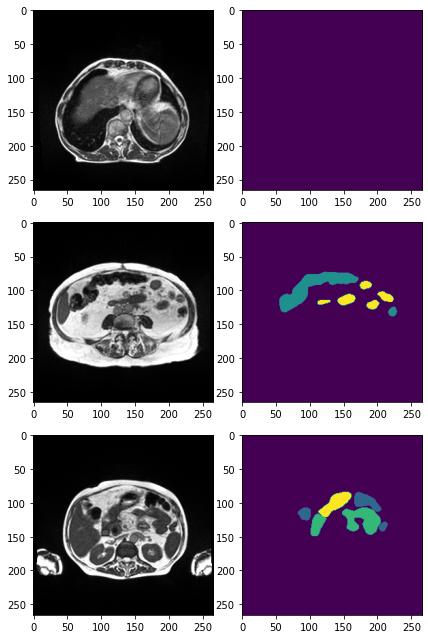

In [11]:
spl_imgs = glob.glob(os.path.join(DATASET_IMAGES, "*", "*.png"))[:3]
fig, axarr = plt.subplots(ncols=2, nrows=len(spl_imgs), figsize=(6, 3 * len(spl_imgs)))

for i, img in enumerate(spl_imgs):
    segm = img.replace(DATASET_IMAGES, DATASET_SEGMS)
    axarr[i, 0].imshow(plt.imread(img))
    axarr[i, 1].imshow(plt.imread(segm))
plt.tight_layout()

## Lightning⚡Flash

lets follow the Semantinc segmentation example: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html

In [12]:
import torch

import flash
from flash.core.data.utils import download_data
from flash.image import SemanticSegmentation, SemanticSegmentationData

### 1. Create the DataModule

See: https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

In [13]:
from dataclasses import dataclass
from typing import Any, Callable, Dict, Mapping, Sequence, Tuple, Union
import albumentations as alb
from flash.core.data.io.input_transform import InputTransform
from flash.image.segmentation.input_transform import prepare_target, remove_extra_dimensions
from kaggle_imsegm.augment import FlashAlbumentationsAdapter

@dataclass
class SemanticSegmentationInputTransform(InputTransform):
    # https://albumentations.ai/docs/examples/pytorch_semantic_segmentation

    image_size: Tuple[int, int] = (128, 128)

    def train_per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([
            alb.Resize(*self.image_size),
            alb.VerticalFlip(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.RandomRotate90(p=0.5),
            alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.05, rotate_limit=15, p=0.5),
            alb.GaussNoise(var_limit=(0.00, 0.03), mean=0, per_channel=False, p=1.0),
            #alb.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            #alb.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
            #alb.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        ])

    def per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([alb.Resize(*self.image_size)])

    def predict_input_per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([alb.Resize(*self.image_size)])

    def target_per_batch_transform(self) -> Callable:
        return prepare_target

    def predict_per_batch_transform(self) -> Callable:
        return remove_extra_dimensions

    def serve_per_batch_transform(self) -> Callable:
        return remove_extra_dimensions

In [14]:
datamodule = SemanticSegmentationData.from_folders(
    train_folder=os.path.join(DATASET_IMAGES, 'train'),
    train_target_folder=os.path.join(DATASET_SEGMS, 'train'),
    val_folder=os.path.join(DATASET_IMAGES, 'val'),
    val_target_folder=os.path.join(DATASET_SEGMS, 'val'),
    #val_split=0.1,
    train_transform=SemanticSegmentationInputTransform,
    val_transform=SemanticSegmentationInputTransform,
    predict_transform=SemanticSegmentationInputTransform,
    transform_kwargs=dict(image_size=(256, 256)),
    num_classes=len(LABELS) + 1,
    batch_size=72,
    num_workers=24,
)

dict_keys([<DataKeys.INPUT: 'input'>, <DataKeys.TARGET: 'target'>, <DataKeys.METADATA: 'metadata'>])


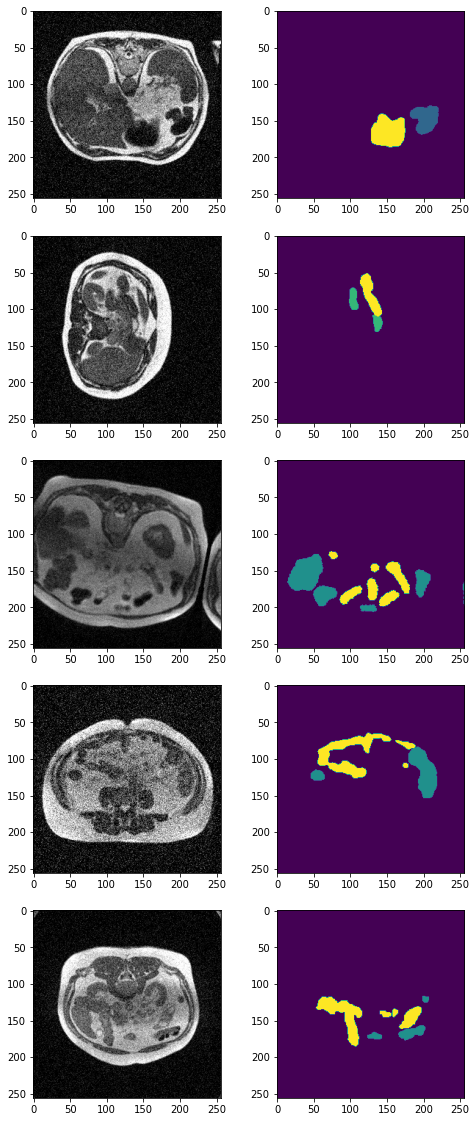

In [15]:
# datamodule.show_train_batch()

fig, axarr = plt.subplots(ncols=2, nrows=5, figsize=(8, 20))
running_i = 0

for batch in datamodule.train_dataloader():
    print(batch.keys())
    for i in range(len(batch['input'])):
        segm = batch['target'][i].numpy()
        if np.sum(segm) == 0 or np.max(segm) <= 1:
            continue
        img = np.rollaxis(batch['input'][i].cpu().numpy(), 0, 3)
        axarr[running_i, 0].imshow(img)
        axarr[running_i, 1].imshow(segm)
        running_i += 1
        if running_i >= 5:
            break
    if running_i >= 5:
        break

### 2. Build the task

In [16]:
model = SemanticSegmentation(
    backbone="resnext50_32x4d",
    head="deeplabv3",
    # pretrained='ssl',
    pretrained=False,
    optimizer="AdamW",
    learning_rate=5e-3,
    num_classes=datamodule.num_classes,
)

/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  rank_zero_warn(
Using 'resnext50_32x4d' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).
Using 'deeplabv3' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).


### 3. Create the trainer and finetune the model

In [17]:
import pytorch_lightning as pl

logger = pl.loggers.CSVLogger(save_dir='logs/')
trainer = flash.Trainer(
    max_epochs=20,
    logger=logger,
    # precision="bf16",
    gpus=1,
    # limit_train_batches=0.25,
    # limit_val_batches=0.25,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.finetune(model, datamodule=datamodule, strategy="no_freeze")

# Save the model!
trainer.save_checkpoint("semantic_segmentation_model.pt")

,train_jaccardindex_step,train_cross_entropy_step,val_jaccardindex,val_cross_entropy,train_jaccardindex_epoch,train_cross_entropy_epoch
epoch,,,,,,
0,0.247258,0.052619,NaN,NaN,NaN,NaN
0,0.245735,0.072870,NaN,NaN,NaN,NaN
0,0.245593,0.069031,NaN,NaN,NaN,NaN
0,0.244757,0.072454,NaN,NaN,NaN,NaN
0,0.245753,0.056015,NaN,NaN,NaN,NaN


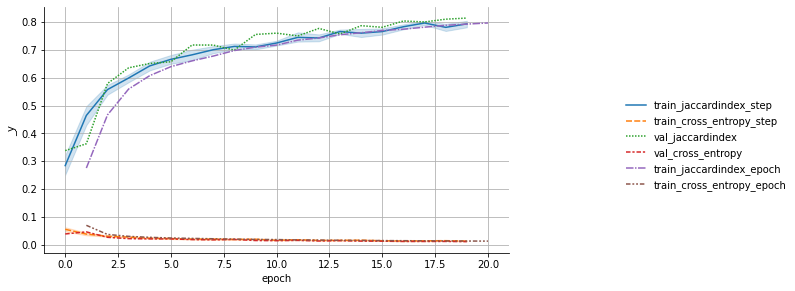

In [19]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()

### 4. Segment a few images!

In [20]:
sample_imgs = glob.glob(os.path.join(DATASET_FOLDER, "test", "**", "*.png"), recursive=True)
if not sample_imgs:
    sample_imgs = glob.glob(os.path.join(DATASET_FOLDER, "train", "**", "*.png"), recursive=True)
print(f"images: {len(sample_imgs)}")
sample_imgs = sample_imgs[:5]

datamodule = SemanticSegmentationData.from_files(
    predict_files=sample_imgs,
    predict_transform=SemanticSegmentationInputTransform,
    transform_kwargs=dict(image_size=(256, 256)),
    batch_size=3,
)

images: 38496


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 524it [00:00, ?it/s]

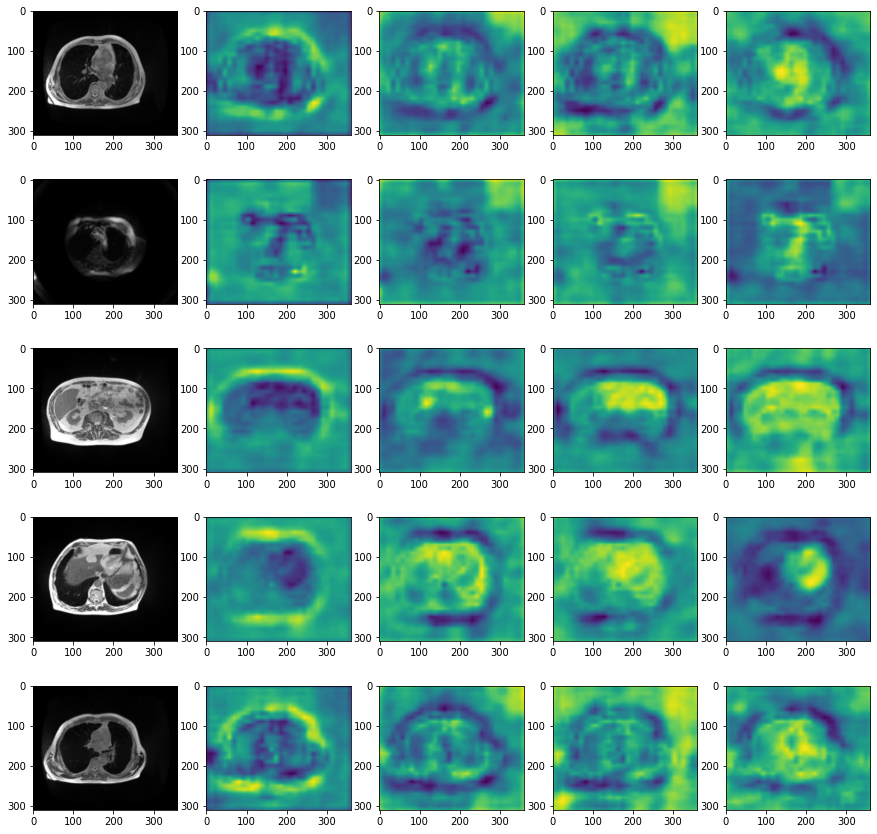

In [21]:
fig, axarr = plt.subplots(ncols=5, nrows=len(sample_imgs), figsize=(15, 3 * len(sample_imgs)))
running_i = 0
for preds in trainer.predict(model, datamodule=datamodule):
    for pred in preds:
        # print(pred.keys())
        img = np.rollaxis(pred['input'].cpu().numpy(), 0, 3)
        axarr[running_i, 0].imshow(img)
        for j, seg in enumerate(pred['preds'].cpu().numpy()):
            axarr[running_i, j + 1].imshow(seg)
        running_i += 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 524it [00:00, ?it/s]

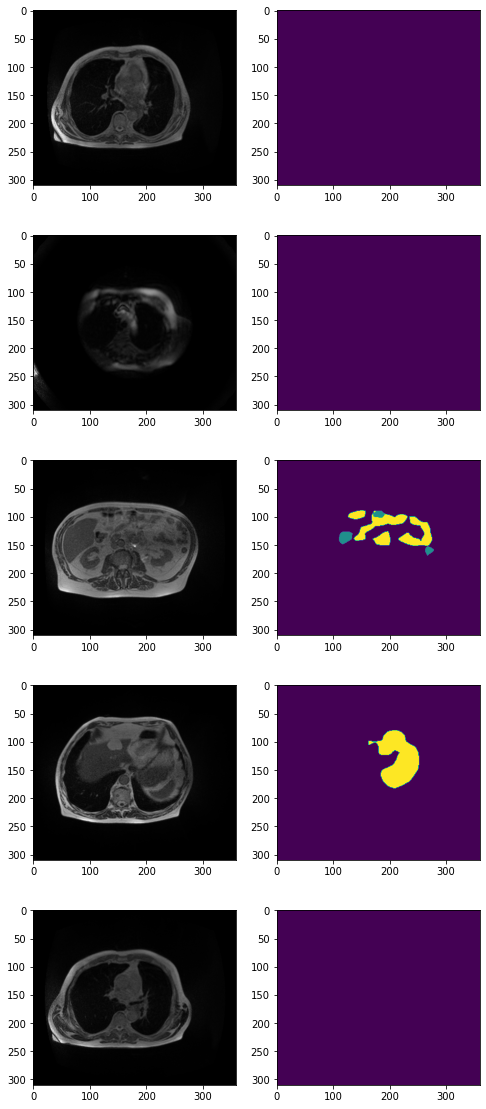

In [22]:
fig, axarr = plt.subplots(ncols=2, nrows=len(sample_imgs), figsize=(8, 4 * len(sample_imgs)))
running_i = 0
for preds in trainer.predict(model, datamodule=datamodule, output="labels"):
    for pred in preds:
        # print(pred)
        img = plt.imread(sample_imgs[running_i])
        axarr[running_i, 0].imshow(img, cmap="gray")
        axarr[running_i, 1].imshow(pred)
        running_i += 1

# Inference

In [23]:
model = SemanticSegmentation.load_from_checkpoint(
    "semantic_segmentation_model.pt"
)

/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metrics'])`.
  rank_zero_warn(
Using 'resnext50_32x4d' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).
Using 'deeplabv3' provided by qubvel/segmentation_models.pytorch (https://github.com/qubvel/segmentation_models.pytorch).


In [24]:
df_test = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
sfolder = "test"
display(df_test.head())

if df_test.empty:
    df_test = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
    df_test = df_test[df_test["id"].str.startswith("case123_day")]
    sfolder = "train"
    display(df_test.head())

os.makedirs(os.path.join(DATASET_IMAGES, sfolder), exist_ok=True)

,id,class,predicted


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [25]:
pprint(extract_tract_details(df_test['id'].iloc[0], DATASET_FOLDER, folder=sfolder))

df_test[['Case','Day','Slice', 'image', 'image_path', 'height', 'width']] = df_test['id'].apply(
    lambda x: pd.Series(extract_tract_details(x, DATASET_FOLDER, folder=sfolder))
)
df_test["Case_Day"] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_test.iterrows()]
display(df_test.head())

{'Case': 123,
 'Day': 20,
 'Slice': '0001',
 'height': 266,
 'image': 'slice_0001_266_266_1.50_1.50.png',
 'image_path': 'train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 'width': 266}


,id,class,segmentation,Case,Day,Slice,image,image_path,height,width,Case_Day
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266,case123_day20
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266,case123_day20


## Predictions for test scans

In [26]:
from itertools import chain
from kaggle_imsegm.mask import rle_encode

preds = []
for _, dfg in df_test.groupby("Case_Day"):
    test_imgs = preprocess_tract_scan(
        dfg,
        dir_data=os.path.join(DATASET_FOLDER, sfolder),
        dir_imgs=DATASET_IMAGES,
        dir_segm=None,
        labels=LABELS,
        sfolder=sfolder,
    )
    dm = SemanticSegmentationData.from_files(
        predict_files=test_imgs,
        predict_transform=SemanticSegmentationInputTransform,
        transform_kwargs=dict(image_size=(256, 256)),
        batch_size=10,
    )
    pred = trainer.predict(model, datamodule=dm, output="labels")
    pred = list(chain(*pred))
    for img, seg in zip(test_imgs, pred):
        rle = rle_encode(np.array(seg)) if np.sum(seg) > 1 else {}
        name, _ = os.path.splitext(os.path.basename(img))
        id_ = "_".join(name.split("_")[:4])
        preds += [{"id": id_, "class": lb, "predicted": rle.get(i + 1, "")} for i, lb in enumerate(LABELS)]

df_pred = pd.DataFrame(preds)
display(df_pred[df_pred["predicted"] != ""])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 524it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 524it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/jirka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 524it [00:00, ?it/s]

,id,class,predicted
146,case123_day0_slice_0049,stomach,31019 7 31284 10 31549 12 31814 13 32079 14 32...
149,case123_day0_slice_0050,stomach,28890 3 29155 6 29420 8 29686 10 29951 12 3021...
152,case123_day0_slice_0051,stomach,27029 1 27294 4 27559 7 27824 10 28089 13 2835...
155,case123_day0_slice_0052,stomach,25698 3 25964 8 26229 10 26495 11 26760 13 270...
158,case123_day0_slice_0053,stomach,20120 2 20384 5 20649 6 20914 7 21180 7 21446 ...
...,...,...,...
1228,case123_day22_slice_0122,small_bowel,12896 13 13160 20 13425 24 13690 31 13955 34 1...
1230,case123_day22_slice_0123,large_bowel,25852 8 26117 16 26382 21 26647 23 26913 23 27...
1231,case123_day22_slice_0123,small_bowel,12896 10 13160 16 13424 23 13689 29 13954 34 1...
1233,case123_day22_slice_0124,large_bowel,26917 15 27183 18 27448 20 27715 18 27981 17 2...


## Finalize submissions

In [27]:
df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
del df_ssub['predicted']
df_pred = df_ssub.merge(df_pred, on=['id','class'])

df_pred[['id', 'class', 'predicted']].to_csv("submission.csv", index=False)

!head submission.csv

id,class,predicted
